# K-Clustering Tool for Edge Devices

## Table of Contents

### 1. Feature Definition and Data Collection
- Select measurable features suitable for edge devices (size, color, brightness, sensor data).
- Collect data from devices or public datasets.
- Normalize and store data efficiently for limited hardware.

### 2. K-Means Classification on Edge Devices
- Implement a lightweight K-Means algorithm optimized for CPU/GPU constraints.
- Use reduced memory operations and optional medoid-style center updates.
- Demonstration: Mango classification using the [dataset](https://www.kaggle.com/code/muhammadmuzammil196/k-mean-mangoes-clustering).
- Compare center initialization methods:
  - Random
  - PCA-based
  - Nearest raw point (K-Medoids approach)
- Final script executes the full pipeline and shows result variation based on initial centers.

### 3. Integration with Split Inference
- Extract features on the edge device to minimize bandwidth.
- Perform clustering locally for real-time classification.
- Offload model retraining to the cloud.
- Synchronize updated cluster centers back to devices with minimal data transfer.



### 1. Define feature and collect data 

### 2. Build algorithm 

In [292]:
# declare a variable and libraries 
import math
# import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time


In [293]:
# config 
train_percent = 0.8
num_clusters = 2
max_iterations = 1000000

In [294]:
def euclidean_distance(point1, point2):
    # Calculate the Euclidean distance between two points use math module because numpy usage a lof of memory
    dis = 0 
    for x_i , y_i in zip(point1, point2):
        dis += (x_i - y_i) ** 2
    return math.sqrt(dis)

# point_1 = [2.0, 3.0]
# point_2 = [5.0, 7.0]

# print(f"Euclidean Distance between {point_1} and {point_2} is: {euclidean_distance(point_1, point_2)}")

In [295]:
import math

def pca_cluster_center(data, k):
    """ Select k cluster centers using PCA-based farthest-point heuristic.
    Args:
        data: list of data points (each is a list of features)        
        k: number of centers to select
    Returns:
        centers: list of k selected centers (each is a list of features)
    """
    # ---------- Helper ----------
    def mean(values): return sum(values) / len(values)
    def dot(a,b): return sum(a[i]*b[i] for i in range(len(a)))
    def norm(v): return math.sqrt(sum(x*x for x in v))
    def mat_vec_mul(M,v): return [dot(row,v) for row in M]

    # 1) Subtract mean
    cols = len(data[0])
    means = [mean([row[i] for row in data]) for i in range(cols)]
    X = [[row[i] - means[i] for i in range(cols)] for row in data]

    # 2) Covariance
    n = len(X)
    cov = [[0]*cols for _ in range(cols)]
    for i in range(cols):
        for j in range(cols):
            s = sum(X[k][i]*X[k][j] for k in range(n))
            cov[i][j] = s / (n - 1)

    # 3) eigenvector via power iteration (only 1 PC -> flatten)
    def power_iteration(M, iter=500):
        v = [1]*len(M)
        for _ in range(iter):
            v = mat_vec_mul(M, v)
            v = [x/norm(v) for x in v]
        return v

    pc1 = power_iteration(cov)

    # 4) Project (flat PCA 1D)
    proj = [dot(row, pc1) for row in X]  # list of scalars

    # 5) Pick k centers using farthest-point heuristic
    used = []
    # pick the point with biggest value first
    first = max(range(len(proj)), key=lambda i: proj[i])
    used.append(first)

    # pick next farthest from current chosen centers
    while len(used) < k:
        idx = max(range(len(proj)), key=lambda i: min(abs(proj[i]-proj[j]) for j in used))
        used.append(idx)

    # 6) Return centers in original space
    centers = [data[i] for i in used]
    return centers

def kmeans(x, y, num_clusters, max_iterations):
    """ Perform K-means clustering.
    Args:       
        x: list of x-coordinates of data points
        y: list of y-coordinates of data points
        num_clusters: number of clusters
        max_iterations: maximum number of iterations
    Returns:
        centers: list of cluster centers
        clusters: list of clusters, each cluster is a list of data points
    """
    # Combine x and y into a list of points
    points = list(zip(x, y))
    # centers = pca_cluster_center(points, num_clusters)
    centers = random.sample(points, num_clusters)
    # plot the initial centers
    plt.scatter([center[0] for center in centers], [center[1] for center in centers], color='black', marker='x', s=100, label='Initial Centers')
    
    for iteration in range(max_iterations):
        clusters = [[] for _ in range(num_clusters)]
        
        # Assign points to the nearest cluster center
        for point in points:
            distances = [euclidean_distance(point, center) for center in centers]
            closest_center = distances.index(min(distances))
            clusters[closest_center].append(point)
        
        # Update cluster centers
        new_centers = []
        for cluster in clusters:
            if cluster:  # Avoid division by zero
                avg_x = sum(p[0] for p in cluster) / len(cluster)
                avg_y = sum(p[1] for p in cluster) / len(cluster)
                new_centers.append((avg_x, avg_y))
            else:
                new_centers.append(random.choice(points))  # Reinitialize empty cluster center
        
        # Check for convergence (if centers do not change)
        if new_centers == centers:
            print(f"Converged after {iteration} iterations.")
            break
        
        centers = new_centers

    # new_centers = get_center((p for p in points), centers)
    new_centers = []
    for center in centers:
        new_centers.append(nearest_point(points, center))
        # print(f"Center: {center} -> Nearest Point: {new_centers[-1]}")
    return new_centers, clusters

In [296]:
def get_center(new_point, centers):
    distances = [euclidean_distance(new_point, center) for center in centers]
    closest_center = distances.index(min(distances))
    return closest_center   
def nearest_point(raw_points, target):
    # target: (x,y) float center
    # raw_points: list of (x,y) real coordinates from your data
    best = None
    best_dist = float("inf")

    for p in raw_points:
        d = math.sqrt((p[0] - target[0])**2 + (p[1] - target[1])**2)
        if d < best_dist:
            best_dist = d
            best = p

    return best



#### Test on mangoes classification 

In [297]:
import pandas as pd
data_path = '../data/mango2.csv'

data = pd.read_csv(data_path)
print(data.head())
print(len(data))

   GreenMango Length  GreenMangowidth  YelloMangoLength  YelloMangoWidth
0               10.2             10.5               5.6              0.6
1                9.8              9.0               5.6              0.6
2                9.4              9.6               5.2              0.6
3                9.2              9.3               6.0              0.6
4               10.0             10.8               5.6              0.6
151


(14.8, 12.0, 19.2, 14.8, 6.0)


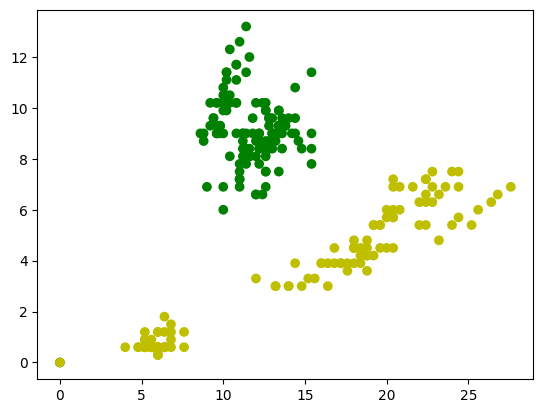

In [298]:
x = list(data['GreenMango Length']) + list(data['YelloMangoLength'])
y = list(data['GreenMangowidth']) + list(data['YelloMangoWidth'])
mango  = [0 for _ in range(len(data['GreenMango Length']))]  + [1 for _ in range(len(data['YelloMangoLength']))]
colors = ['g' , 'y']

pairs = list(zip(x, y, mango))  # Combine them as pairs
random.shuffle(pairs)    # Shuffle the pairs
x, y, mango = zip(*pairs)     # Unzip the pairs back into x and y

train_percent = int(len(x) * train_percent)
x_train , x_test = x[:train_percent], x[train_percent:]
y_train , y_test = y[:train_percent], y[train_percent:]
mango_train , mango_test = mango[:train_percent], mango[train_percent:]

print(x_train[:5])
plt.scatter(x_train, y_train, color=[colors[label] for label in mango_train], marker='o')


(14.8, 12.0, 19.2, 14.8, 6.0)
Converged after 3 iterations.
Centers [(10.0, 6.9), (20.4, 5.7)]


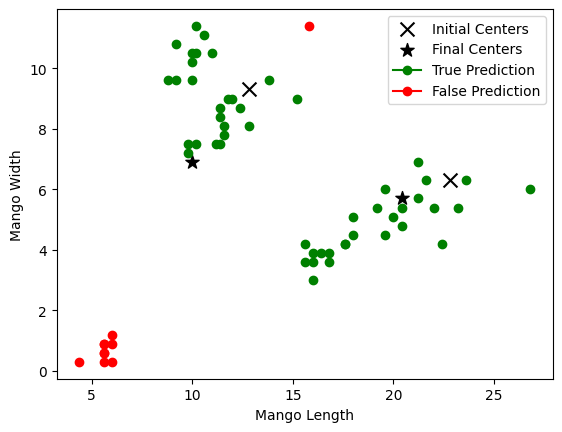

True Predictions: 51, False Predictions: 10


In [314]:
def test_kmeans(x_test , y_test , mango_test):
    print(x_train[:5])
    center, cluster = kmeans(x_train , y_train , num_clusters, max_iterations)
    pred_mangoes = []
    print("Centers", center)
    plt.scatter([c[0] for c in center], [c[1] for c in center], color='black', marker='*', s=100, label='Final Centers')
    for i in range(len(center)):
        for j in range(len(x_train)):
            if x_train[j] == center[i][0] and y_train[j] == center[i][1]:
                pred_mangoes.append(mango_train[j])
                break
    true_predict = 0 
    false_predict = 0
    for i in range(len(x_test)):
        closet_center = get_center((x_test[i], y_test[i]), center)
        if mango_test[i] == pred_mangoes[closet_center]:
            plt.plot(x_test[i], y_test[i], color='g', marker='o' , label='True Prediction' if true_predict ==0 else "")
            true_predict += 1
        else:
            plt.plot(x_test[i], y_test[i], color='r', marker='o' , label='False Prediction' if false_predict ==0 else "")
            false_predict += 1
    plt.legend()
    plt.xlabel('Mango Length')
    plt.ylabel('Mango Width')
    plt.show()
    print(f"True Predictions: {true_predict}, False Predictions: {false_predict}")


test_kmeans(x_test , y_test , mango_test)